In [2]:
# import time
import os
from skimage import io
import scipy as sp
import numpy as np
# import sys
import openpnm as op
import porespy as ps
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import rcParams
np.set_printoptions(precision=4)
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import math

In [3]:
print(op.__version__)
print(ps.__version__)
print(np.__version__)


2.8.2
2.2.2
1.20.1


In [4]:
# Matplotlib plotting controls
plt.rc('axes', linewidth=2)
plt.rc('font', weight='bold')
params = {'figure.autolayout': True,
          'figure.titleweight': 'bold',
          'font.weight': 'bold',
          'font.size': 14,
          'font.family': 'sans-serif',
          'font.sans-serif': 'Arial',
          'legend.fontsize': 12,
#           'legend.title_fontsize':10,
          'figure.figsize': (6, 5),
          'figure.titlesize': 14,
          'axes.labelsize': 12,
          'axes.labelweight': 'bold',
          'axes.titlesize': 14,
          'axes.linewidth': 2,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'xtick.direction': 'in',
          'ytick.direction': 'in',
          'xtick.top': True,
          'xtick.bottom': True,
          'xtick.labeltop': False,
          'xtick.labelbottom': True,
          'ytick.left': True,
          'ytick.right': True,
          'ytick.labelright': False,
          'ytick.labelleft': True,
          'ytick.major.size': 5.5,
          'ytick.major.width': 0.8,
          'xtick.major.size': 5.5,
          'xtick.major.width': 0.8,
          'ytick.minor.size': 3.5,
          'ytick.minor.width': 0.6,
          'xtick.minor.size': 3.5,
          'xtick.minor.width': 0.6,
        'xtick.minor.visible':True,
         'ytick.minor.visible':True}
rcParams.update(params)

# Step1: Read in files and prep work

In [5]:
#Read in all tif stacks

voxel_size = 6e-9

numSamples = 3
numRegions = 6

sampleNames = ['pris','uncomp','comp']
regionIndicators = list(range(1,numRegions+1))

im = []

path = 'data/1p2um volumes/'
for i,x in enumerate(sampleNames):
    im_temp = []
    for j,y in enumerate(regionIndicators):
        im_temp.append(io.imread(path+x+'_1p2um/'+x+'_1p2um_'+str(y)+'.tif'))
    im.append(im_temp)
        
#separate solid and void
im_solid = []
im_void = []

for i,x in enumerate(im):
    solid_temp = []
    void_temp = []
    for j, y in enumerate(x):
        solid_temp.append(y != 0)
        void_temp.append(y == 0)
    im_solid.append(solid_temp)
    im_void.append(void_temp)

im_solid = np.array(im_solid)
im_void = np.array(im_void)

im_total = [im_solid, im_void]
im_total = np.array(im_total)

#check
print('im_solid array shape:', im_solid.shape)
print('im_void array shape:',im_void.shape)
print()
print('im_total array shape:',im_total.shape)

im_solid array shape: (3, 6, 200, 200, 200)
im_void array shape: (3, 6, 200, 200, 200)

im_total array shape: (2, 3, 6, 200, 200, 200)


In [6]:
#Restore the snow network extractions if needed
%store -r snow_solid
%store -r snow_void

In [7]:
#Create OpenPNM project objects
proj_solid = []
proj_void = []

for x in snow_solid:
    proj_temp = []
    for y in x:
        proj_temp.append(op.io.PoreSpy.import_data(y.network))
    proj_solid.append(proj_temp)
    
for x in snow_void:
    proj_temp = []
    for y in x:
        proj_temp.append(op.io.PoreSpy.import_data(y.network))
    proj_void.append(proj_temp)
    

proj_total = [proj_solid, proj_void]



In [8]:
#Divide project objects into network and geometry objects
pn = []
geo = []
for phase in proj_total:
    phase_pn_temp = []
    phase_geo_temp = []
    for sample in phase:
        sample_pn_temp = []
        sample_geo_temp = []
        for i,region in enumerate(sample):
            sample_pn_temp.append(region[0])
            sample_geo_temp.append(region[1])
        phase_pn_temp.append(sample_pn_temp)
        phase_geo_temp.append(sample_geo_temp)
    pn.append(phase_pn_temp)
    geo.append(phase_geo_temp)

In [9]:
print(test_geo)

NameError: name 'test_geo' is not defined

In [11]:
test_region = pn[0][0][0]
test_geo = geo[0][0][0]

# print(test_geo)
print('pore diameter:')
print(test_geo['pore.diameter'])
print(test_geo['pore.extended_diameter'])
print()
print('throat diameter:')
print(test_geo['throat.diameter'])
print(test_geo['throat.inscribed_diameter'])
print()
print('pore volume:')
print(test_geo['pore.volume'])
test_volume = op.models.geometry.pore_volume.sphere(test_region,pore_diameter='pore.equivalent_diameter')
print(test_volume)
print()
print('throat length:')
print(test_geo['throat.length'])
conduit_lengths = op.models.geometry.conduit_lengths.cones_and_cylinders(test_geo)
test_throat_length = conduit_lengths[:,1]
print(test_throat_length)
print()
print('diffusive_size_factors')
print(test_geo['throat.diffusive_size_factors.pore1'])
diffusive_size_factors = op.models.geometry.diffusive_size_factors.cones_and_cylinders(test_geo)
print(diffusive_size_factors['pore1'])



pore diameter:
[1.2000e-07 1.0933e-07 6.9971e-08 ... 8.4853e-08 1.0392e-07 6.0000e-08]
[1.2000e-07 1.0933e-07 6.9971e-08 ... 8.4853e-08 1.0392e-07 6.0000e-08]

throat diameter:
[8.5697e-08 4.8000e-08 6.7882e-08 ... 3.3941e-08 4.9477e-08 4.9477e-08]
[8.5697e-08 4.8000e-08 6.7882e-08 ... 3.3941e-08 4.9477e-08 4.9477e-08]

pore volume:
[3.5143e-22 6.1387e-22 1.4580e-22 ... 3.1104e-23 3.2400e-23 1.9440e-24]
[3.5143e-22 6.1387e-22 1.4580e-22 ... 3.1104e-23 3.2400e-23 1.9440e-24]

throat length:
[1.0000e-15 3.1947e-08 2.3416e-09 ... 1.0000e-15 1.0000e-15 1.0000e-15]
[1.0000e-15 3.1947e-08 2.3416e-09 ... 1.0000e-15 1.0000e-15 1.0000e-15]

diffusive_size_factors
[2.0420e-07 7.5398e-08 1.0663e-07 ... 1.2435e-07 4.9394e-07 5.1023e-07]
[2.0420e-07 7.5398e-08 1.0663e-07 ... 1.2435e-07 4.9394e-07 5.1023e-07]


In [12]:
    
#adjusting area due to errors
for phase in geo:
    for sample in phase:
        for region in sample:
            region["pore.area"] = np.pi * np.square(region['pore.diameter']/2)
            region['throat.area'] = region['throat.cross_sectional_area']

model1 = op.models.geometry.conduit_lengths.spheres_and_cylinders
for p,phase in enumerate(pn):
    for s,sample in enumerate(phase):
        for r,region in enumerate(sample):
            # temp = model1(region,pore_diameter='pore.diameter', throat_diameter='throat.diameter')

            # pore1 = []
            # throat = []
            # pore2 = []
            # for array in temp:
            #     pore1.append(array[0])
            #     throat.append(array[1])
            #     pore2.append(array[2])

            # geo[p][s][r]['throat.conduit_lengths.pore1'] = pore1
            # geo[p][s][r]['throat.conduit_lengths.pore2'] = pore2
            # geo[p][s][r]['throat.conduit_lengths.throat'] = throat
            # geo[p][s][r].regenerate_models()

            #checking network health
            h = region.check_network_health()
#             print(h)

            op.topotools.trim(network=region, pores=h['trim_pores'])
            h = region.check_network_health()
#             print(h)
            
            #plot PNM
#             fig = op.topotools.plot_connections(network=region, alpha=1, linewidth=0.5)
#             fig = op.topotools.plot_coordinates(network=region,ax=fig, color='r',markersize=0.1)
#             plt.savefig('{}_PNM.png'.format(sampleNames[i]),transparent = True, dpi = 400, bbox_inches='tight')



# Step 2: Formation Factor, Kf

In [13]:
#Formation factor, using ohmic conduction algorithm 
totVol = []
kf = []
oc = []
#Direction names that correspond to OpenPNM's x, y, and z
#x and z are switched from taufactor, y is still through-plane
directionNames = ['In-plane depth','Through-plane','In-plane width']
directions = [['xmin','xmax'],['ymin','ymax'],['zmin','zmax']]

for p,phase in enumerate(pn):
    phase_totVol_temp = []
    phase_kf_temp = []
    oc_phase = []

    for s,sample in enumerate(phase):
        sample_totVol_temp = []
        sample_kf_temp = []
        oc_sample = []

        for r,region in enumerate(sample):

            #create generic phase
            phase_generic = op.phases.GenericPhase(network=region)
            phase_generic['pore.electrical_conductivity'] = 1

            #create generic physics
            physics_generic = op.physics.Standard(network=region,  phase=phase_generic, geometry=geo[p][s][r])
            print(physics_generic)
            
            
            pore_volumes = np.sum(region['pore.volume'])
            throat_volumes = np.sum(region['throat.volume'])
            totV = pore_volumes + throat_volumes
            sample_totVol_temp.append(totV)
            
            
            direction_kf_temp = []
            #iterate through all 3 directions, x y and z
            for d in range(3):

                #label inlet, outlet
                inlets = region.pores(labels=directions[d][1])
                outlets = region.pores(labels=directions[d][0])

                # ohmic conduction algorithm
                oc_i = op.algorithms.OhmicConduction(network=region,phase=phase_generic)
                oc_i.settings['conductance'] = 'throat.electrical_conductance'


                # Dirichlet BCs: inlet= 1 V, outlet = 0 V
                vL, vR = 1.0, 0.0
                oc_i.set_value_BC(pores=inlets,values=vL)
                oc_i.set_value_BC(pores=outlets, values=vR)

                #run ohmic conduction
                oc_i.run()
                if d==1:
                    oc_sample.append(oc_i)

                #plot
                fig, ax = plt.subplots(figsize=[6, 6])
                op.topotools.plot_coordinates(ax=ax,
                                          network=region,
                                          size_by=region["pore.diameter"],
                                          color_by=oc_i["pore.voltage"],
                                          markersize=100)
                plt.axis('on')
                plt.show()

                #L = length between inlet and outlet faces
                L = im_total[p][s][r].shape[d]*voxel_size

                # area of inlet (and outlet)
                A = (im_total[p][s][r].shape[(d+1)%3]*voxel_size)*(im_total[p][s][r].shape[(d+2)%3]*voxel_size)
    
                sigma_eff = oc_i.calc_effective_conductivity(inlets=inlets, outlets=outlets,
                                                    domain_area=A, domain_length=L)[0]
                print(sigma_eff)

                direction_kf_temp.append(sigma_eff)
            sample_kf_temp.append(direction_kf_temp)
        oc_phase.append(oc_sample)
        phase_kf_temp.append(sample_kf_temp)
        phase_totVol_temp.append(sample_totVol_temp)
    kf.append(phase_kf_temp)
    totVol.append(phase_totVol_temp)
    oc.append(oc_phase)
    

    

------------------------------------------------------------
ERROR      : throat.flow_shape_factors was not run since the following property is
             missing: 'throat.conduit_lengths.pore1' 
SOURCE     : openpnm.core.ModelsMixin._regen 
TIME STAMP : 2025-09-10 14:00:41,822
------------------------------------------------------------
------------------------------------------------------------
ERROR      : throat.hydraulic_conductance was not run since the following property is
             missing: 'throat.conduit_lengths.pore1' 
SOURCE     : openpnm.core.ModelsMixin._regen 
TIME STAMP : 2025-09-10 14:00:41,828
------------------------------------------------------------
------------------------------------------------------------
ERROR      : throat.poisson_shape_factors was not run since the following property is
             missing: 'throat.conduit_lengths.pore1' 
SOURCE     : openpnm.core.ModelsMixin._regen 
TIME STAMP : 2025-09-10 14:00:41,831
-----------------------------

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.physics.Standard : phys_01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Labels                                        Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.all                                      1888      
2     throat.all                                    4286      
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


KeyError: 'throat.electrical_conductance'

# Imbibition and water retention curves

In [84]:
#Create OpenPNM project objects
proj_solid = []
proj_void = []

for x in snow_solid:
    proj_temp = []
    for y in x:
        proj_temp.append(op.io.PoreSpy.import_data(y.network))
    proj_solid.append(proj_temp)
    
for x in snow_void:
    proj_temp = []
    for y in x:
        proj_temp.append(op.io.PoreSpy.import_data(y.network))
    proj_void.append(proj_temp)
    

proj_total = [proj_solid, proj_void]



In [85]:
#Divide project objects into network and geometry objects
pn = []
geo = []
for phase in proj_total:
    phase_pn_temp = []
    phase_geo_temp = []
    for sample in phase:
        sample_pn_temp = []
        sample_geo_temp = []
        for i,region in enumerate(sample):
            sample_pn_temp.append(region[0])
            sample_geo_temp.append(region[1])
        phase_pn_temp.append(sample_pn_temp)
        phase_geo_temp.append(sample_geo_temp)
    pn.append(phase_pn_temp)
    geo.append(phase_geo_temp)

In [86]:
    
#adjusting area due to errors
# for phase in geo:
#     for sample in phase:
#         for region in sample:
#             region["pore.area"] = np.pi * np.square(region['pore.diameter']/2)
#             region['throat.area'] = region['throat.cross_sectional_area']

model1 = op.models.geometry.conduit_lengths.spheres_and_cylinders
for p,phase in enumerate(pn):
    for s,sample in enumerate(phase):
        for r,region in enumerate(sample):
            # temp = model1(region,pore_diameter='pore.diameter', throat_diameter='throat.diameter')

            # pore1 = []
            # throat = []
            # pore2 = []
            # for array in temp:
            #     pore1.append(array[0])
            #     throat.append(array[1])
            #     pore2.append(array[2])

            # geo[p][s][r]['throat.conduit_lengths.pore1'] = pore1
            # geo[p][s][r]['throat.conduit_lengths.pore2'] = pore2
            # geo[p][s][r]['throat.conduit_lengths.throat'] = throat
            # geo[p][s][r].regenerate_models()

            #checking network health
            h = region.check_network_health()
#             print(h)

            op.topotools.trim(network=region, pores=h['trim_pores'])
            h = region.check_network_health()
#             print(h)
            
            #plot PNM
#             fig = op.topotools.plot_connections(network=region, alpha=1, linewidth=0.5)
#             fig = op.topotools.plot_coordinates(network=region,ax=fig, color='r',markersize=0.1)
#             plt.savefig('{}_PNM.png'.format(sampleNames[i]),transparent = True, dpi = 400, bbox_inches='tight')



In [87]:
#Defining Phase (from MA)
#-----------------------------------------------------------------------------

#Only do on Void Phase (phase=1, so pn[1] = void phase data)


mods = op.models


# Creating O2 custom phase
O2 = []
for s,sample in enumerate(pn[1]):
    sample_O2_temp = []
    for r,region in enumerate(sample):
        O2_i = op.phases.GenericPhase(network=region)
        # O2_i['pore.molecular_weight'] = 0.0319988 #kg/mol
        # O2_i['pore.critical_pressure'] = 5.043 #MPa, Cardoso, 1915
        # O2_i['pore.critical_temperature'] = 155.15 #K, Cardoso, 1915
        # O2_i['pore.critical_volume'] = 0.0025 #m3/kg, Engineering Toolbox
        O2_i['pore.contact_angle'] = 105
        O2_i['pore.surface_tension'] = 0.0626 # of water N/m @ 80C
        # O2_i['pore.temperature'] = 80 + 273.15 #K
        # O2_i.add_model(propname='pore.molar_density',
        #            model=mods.phases.molar_density.ideal_gas)
        # O2_i.add_model(propname='pore.diffusivity',
        #            model=mods.misc.constant,
        #            value = 29.1
#                        MA=0.032, MB=0.02897,
#                    vA=16.6, vB=20.1
                    #   ) #O2 and air moleuclar weights and diffusion volumes
                                    #http://websites.umich.edu/~elements/course/lectures/eleven/exam4.htm
#         O2_i.add_model(propname='pore.thermal_conductivity',
#                    model=mods.misc.constant,
#                    value = 0.026
# #                    prop='pore.temperature',
# #                    a=[-0.001285, 0.000107, -0.00000005263, 
# #                       0.00000000002568, -5.04E-015]
#                     )
#         O2_i.add_model(propname='pore.electrical_conductivity',
#                    model=mods.misc.constant,
#                    value=1e-15)
#         O2_i.add_model(propname='pore.viscosity',
#                    model=mods.misc.polynomial,
#                    prop='pore.temperature',
#                    a=[-0.000001,9.262500e-08,-8.065700e-11,
#                       5.113000e-14,-1.295000e-17])  
        sample_O2_temp.append(O2_i)
    O2.append(sample_O2_temp)

#Adding water phase with specific wettalbility
H2O = []
for s,sample in enumerate(pn[1]):
    sample_water_temp = []
    for r,region in enumerate(sample):
        H2O_i = op.phases.Water(network = region)
        # H2O_i['pore.temperature'] = 80 + 273.15
        H2O_i['pore.contact_angle'] =  75  #wettability
        H2O_i['pore.surface_tension'] = 0.0626 # of water N/m @ 80C
#         H2O_i['throat.contact_angle'] =  75  #wettability
#         H2O_i['throat.surface_tension'] = 0.0626 # of water N/m @ 80Cchhh=c
        sample_water_temp.append(H2O_i)
    H2O.append(sample_water_temp)


In [88]:
print(H2O[1][0]['throat.contact_angle'])
print(O2[1][0]['throat.contact_angle'])

[75. 75. 75. ... 75. 75. 75.]
[105. 105. 105. ... 105. 105. 105.]


In [89]:
# Defining Physics (From MA)
#-----------------------------------------------------------------------------

# #Oxygen
phys_oxygen = []
for s,sample in enumerate(O2):
    sample_O2_temp = []
    for r,region in enumerate(sample):
        physics_o = op.physics.Standard(network=pn[1][s][r],  phase=region, geometry=geo[1][s][r])
        physics_o.add_model(model=mods.physics.capillary_pressure.washburn,
                             propname='pore.entry_pressure',
                             surface_tension="pore.surface_tension",
                             contact_angle="pore.contact_angle",
                             diameter="pore.diameter",
                            )
        physics_o.add_model(model=mods.physics.capillary_pressure.washburn,
                             propname='throat.entry_pressure',
                             surface_tension="throat.surface_tension",
                             contact_angle="throat.contact_angle",
                             diameter="throat.diameter",
                            )
        sample_O2_temp.append(physics_o)
    phys_oxygen.append(sample_O2_temp)

#Water
phys_water = []
for s,sample in enumerate(H2O):
    sample_H2O_temp = []
    for r,region in enumerate(sample):
        physics_w = op.physics.Standard(network=pn[1][s][r],  phase=region, geometry=geo[1][s][r])
        physics_w.add_model(model=mods.physics.capillary_pressure.washburn,
                             propname='pore.entry_pressure',
                             surface_tension="pore.surface_tension",
                             contact_angle="pore.contact_angle",
                             diameter="pore.diameter",
                            )
        physics_w.add_model(model=mods.physics.capillary_pressure.washburn,
                             propname='throat.entry_pressure',
                             surface_tension="throat.surface_tension",
                             contact_angle="throat.contact_angle",
                             diameter="throat.diameter",
                            )#Capillary pressure, Young-Laplace
        sample_H2O_temp.append(physics_w)
    phys_water.append(sample_H2O_temp)

------------------------------------------------------------
ERROR      : throat.flow_shape_factors was not run since the following property is
             missing: 'pore.area' 
SOURCE     : openpnm.core.ModelsMixin._regen 
TIME STAMP : 2025-09-10 14:39:05,465
------------------------------------------------------------
------------------------------------------------------------
ERROR      : throat.hydraulic_conductance was not run since the following property is
             missing: 'pore.area' 
SOURCE     : openpnm.core.ModelsMixin._regen 
TIME STAMP : 2025-09-10 14:39:05,473
------------------------------------------------------------
------------------------------------------------------------
ERROR      : throat.poisson_shape_factors was not run since the following property is
             missing: 'pore.area' 
SOURCE     : openpnm.core.ModelsMixin._regen 
TIME STAMP : 2025-09-10 14:39:05,496
------------------------------------------------------------
-------------------------

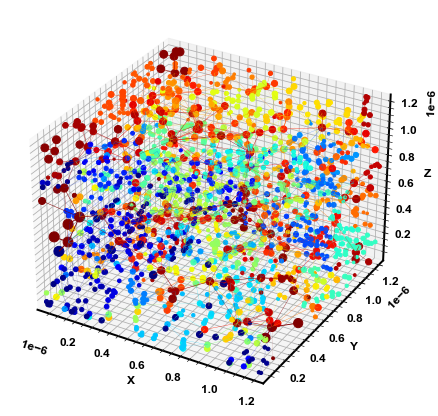

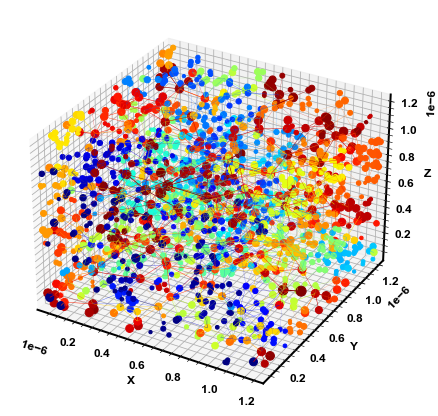

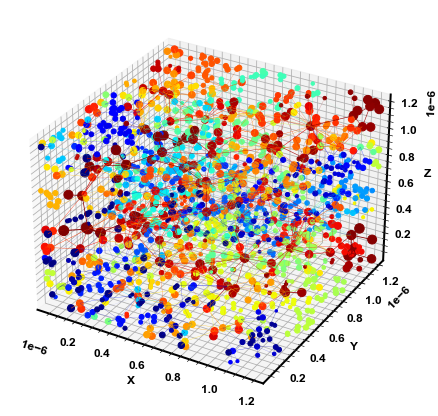

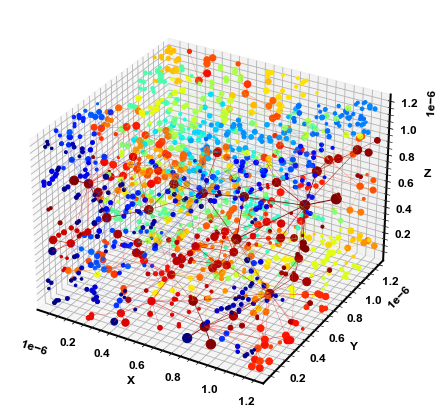

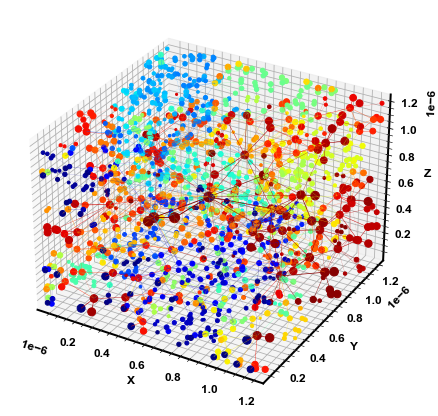

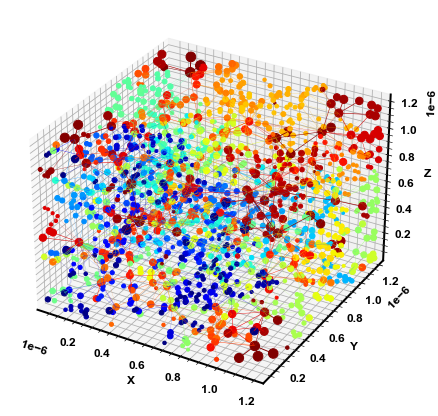

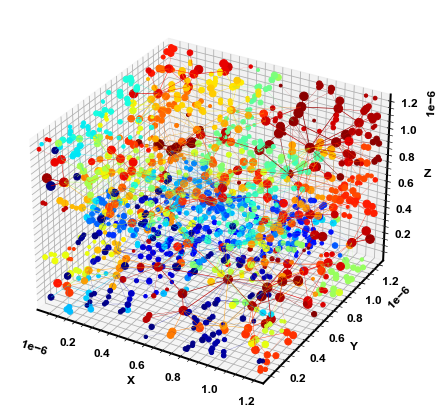

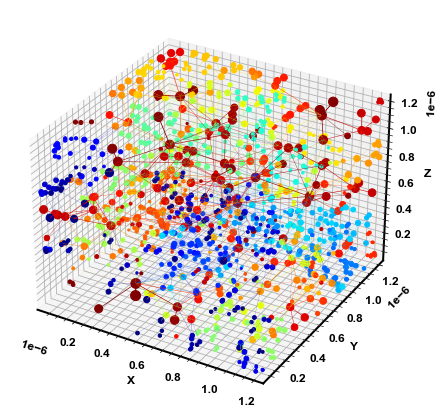

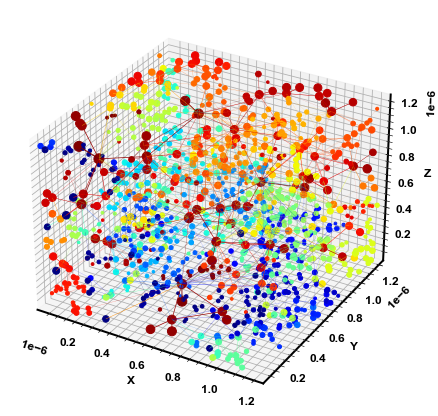

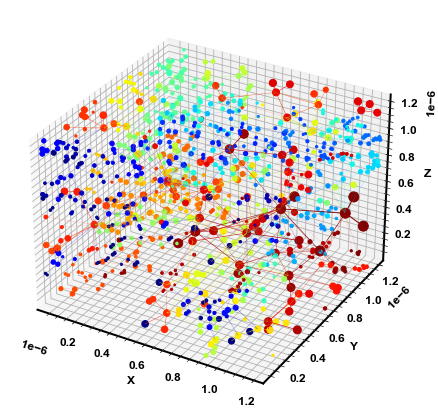

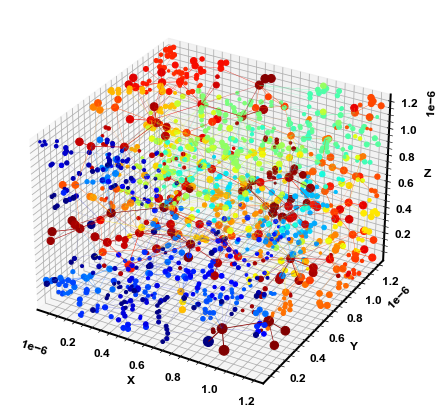

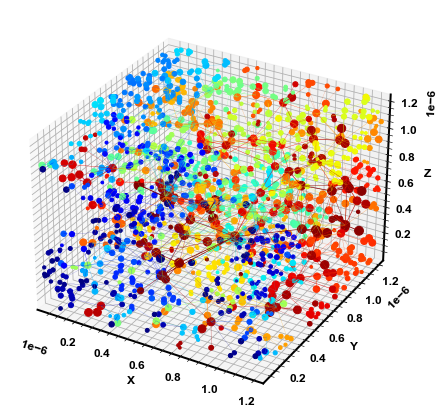

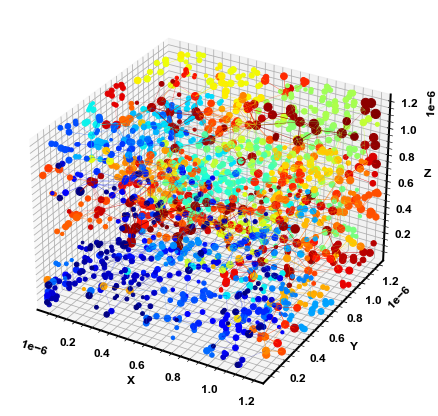

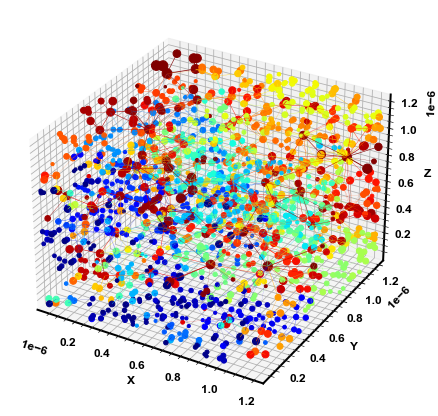

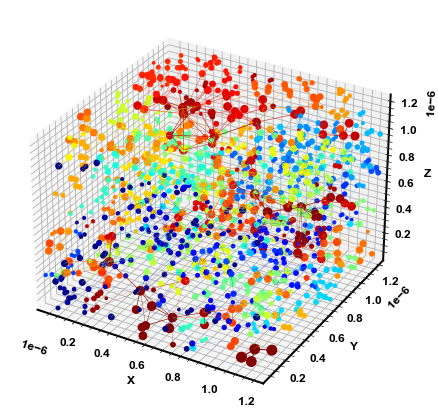

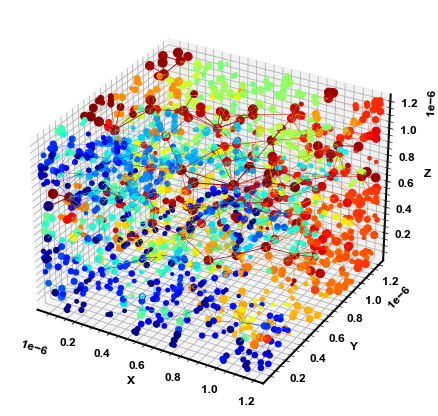

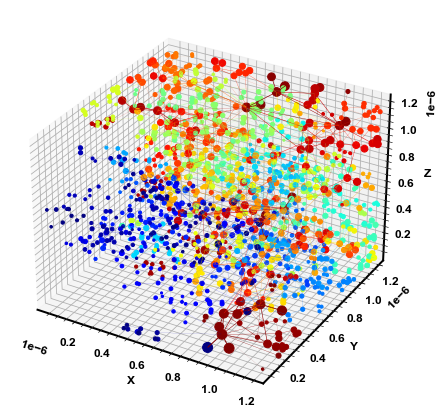

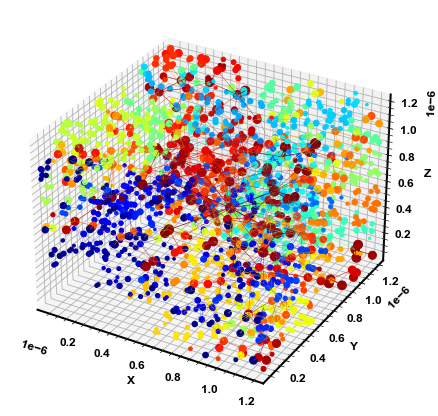

In [80]:
#Imbibtion algorithm to invade pores with water (from MA)

directionNames = ['In-plane depth','Through-plane','In-plane width']
directions = [['xmin','xmax'],['ymin','ymax'],['zmin','zmax']]

IMB = []
for s,sample in enumerate(pn[1]):
    sample_IMB = []
    for r, region in enumerate(sample):

        inlets = region.pores(directions[1][0])
        used_inlets = [inlets[y] for y in range(0, len(inlets), 2)]
        op.algorithms.MixedInvasionPercolation(network=region).reset()
        perc = op.algorithms.MixedInvasionPercolation(network=region)
        perc.setup(phase = H2O[s][r])
        perc.set_inlets(pores = used_inlets)
        perc.run()
#             print(perc)
        fig, ax = plt.subplots(figsize=[6, 6])

        op.topotools.plot_coordinates(ax=ax,
                                  network=region,
                                  size_by=region["pore.diameter"],
                                  color_by=perc["pore.invasion_sequence"],
                                  markersize=100)
        op.topotools.plot_connections(ax=ax,
                                  network=region,
                                  size_by=region["throat.diameter"],
                                  color_by=perc["throat.invasion_sequence"],
#                                   linesize=10
                                     )
    
        
        plt.axis('on')
        plt.show()

        sample_IMB.append(perc)
    IMB.append(sample_IMB)
            
            

In [81]:
#analyze imbibition data
raw_data = []
pc = []
sat_tot = []
# sat_throat = []
# sat_pore = []


for s,sample in enumerate(IMB):
    sample_raw_data = []
    sample_pc = []
    sample_sat_tot = []
    for r,region in enumerate(sample):
        region_raw_data = []
        region_pc = []
        region_sat_tot = []
        
        data_i = region.get_intrusion_data()
        region_sat_tot.append(data_i.S_tot[0]) 
        region_pc.append(data_i.Pcap[0])
        
        for i,x in enumerate(data_i.S_tot):
            if  data_i.S_tot[i] - region_sat_tot[-1] > 0:
                region_pc.append(data_i.Pcap[i])
                region_sat_tot.append(data_i.S_tot[i])
                    
        sample_raw_data.append(data_i)
        sample_pc.append(region_pc)
        sample_sat_tot.append(region_sat_tot)
    raw_data.append(sample_raw_data)
    pc.append(sample_pc)
    sat_tot.append(sample_sat_tot)

In [90]:
#Drainage

directionNames = ['In-plane depth','Through-plane','In-plane width']
directions = [['xmin','xmax'],['ymin','ymax'],['zmin','zmax']]

Drainage = []
for s,sample in enumerate(pn[1]):
    sample_drain = []
    for r, region in enumerate(sample):

        inlets = region.pores(directions[1][0])
        used_inlets = [inlets[y] for y in range(0, len(inlets), 2)]
        op.algorithms.MixedInvasionPercolation(network=region).reset()
        drain = op.algorithms.MixedInvasionPercolation(network=region)
        drain.setup(phase = O2[s][r])
        drain.set_inlets(pores = used_inlets)
        drain.run()
#             print(perc)
#         fig, ax = plt.subplots(figsize=[6, 6])

#         op.topotools.plot_coordinates(ax=ax,
#                                   network=region,
#                                   size_by=region["pore.diameter"],
#                                   color_by=perc["pore.invasion_sequence"],
#                                   markersize=100)
#         op.topotools.plot_connections(ax=ax,
#                                   network=region,
#                                   size_by=region["throat.diameter"],
#                                   color_by=perc["throat.invasion_sequence"],
# #                                   linesize=10
#                                      )
    
        
#         plt.axis('on')
#         plt.show()

        sample_drain.append(drain)
    Drainage.append(sample_drain)

In [91]:
#analyze drainage data
raw_data_drain = []
pc_drain = []
sat_tot_drain = []
# sat_throat = []
# sat_pore = []


for s,sample in enumerate(Drainage):
    sample_raw_data = []
    sample_pc = []
    sample_sat_tot = []
    for r,region in enumerate(sample):
        region_raw_data = []
        region_pc = []
        region_sat_tot = []
        
        data_i = region.get_intrusion_data()
        region_sat_tot.append(data_i.S_tot[0]) 
        region_pc.append(data_i.Pcap[0])
        
        for i,x in enumerate(data_i.S_tot):
            if  data_i.S_tot[i] - region_sat_tot[-1] > 0:
                region_pc.append(data_i.Pcap[i])
                region_sat_tot.append(data_i.S_tot[i])
                    
        sample_raw_data.append(data_i)
        sample_pc.append(region_pc)
        sample_sat_tot.append(region_sat_tot)
    raw_data_drain.append(sample_raw_data)
    pc_drain.append(sample_pc)
    sat_tot_drain.append(sample_sat_tot)

In [65]:
print(pc[0][0])

[-2415262.2890668456, -1909432.5557540345, -1800230.2470464222, -1497882.1204889335, -1350172.6852848167, -1309859.9361868384, -1272955.0729367202, -1207631.1445334228, -1151431.1104249519, -1102411.3410783627, -1080138.1482278535, -1059162.5923534555, -1039363.4602352029, -1002883.1064961028, -986026.6780273229, -940139.5881391813, -912883.318506528, -900115.1235232111, -887868.0611656051, -876107.7376301357, -853924.1736537353, -843446.1773275293, -814184.7415383062, -805087.4583028379, -796288.401234211, -779522.5772927206, -771527.2487341809, -763773.0094253635, -748941.0602444668, -741841.9266210889, -734940.9178971484, -721697.6363598865, -715338.981135257, -709145.427339943, -703110.0534413565, -691487.580508674, -685888.4250080253, -675086.3426424083, -669873.2411447094, -664779.0517795318, -659799.4229709979, -654929.9680934192, -650166.793750268, -645506.0260440477, -636477.5364683601, -632103.0591324545, -627817.5336601314, -623618.018913344, -619501.6903093428, -615465.8339

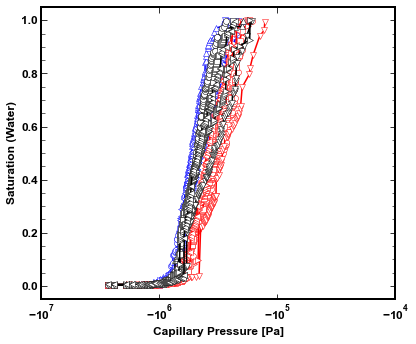

In [66]:
#Plot S_tot intrusion curves for all samples and regions
fig1, ax1 = plt.subplots(1, 1)
line_colors =['k','r','b']
shapes = ['^','o','s','v','>','<']
zorders = [100,99,98]

for s,sample in enumerate(pc):
    for r,region in enumerate(sample):
#         if s==1 and r==2:
            ax1.plot(region,sat_tot[s][r],color = line_colors[s], marker = shapes[r], 
                     markeredgewidth=0.5, markerfacecolor='white',zorder=zorders[s])
        
# ax1.legend(loc = 'best')
ax1.set_xlabel("Capillary Pressure [Pa]")
ax1.set_ylabel("Saturation (Water)")
ax1.set_xscale('symlog')
ax1.set_xlim([-10**7, -10**4])
plt.tick_params(axis='x', which='minor')
# ax1.set_title('Total Saturation', fontweight = 'bold')
# plt.savefig('imbibition_all_allpoints.png',\
#                 transparent = True, dpi = 400, bbox_inches='tight')

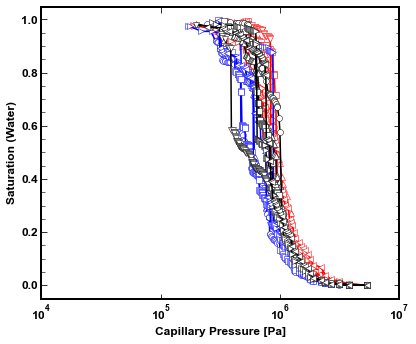

In [104]:
#Plot S_tot intrusion curves for all samples and regions
fig1, ax1 = plt.subplots()
line_colors =['k','b','r']
shapes = ['^','o','s','v','>','<']
zorders = [100,99,98]

for s,sample in enumerate(pc_drain):
    for r,region in enumerate(sample):
#         if s==1 and r==2:
            ax1.plot(np.array(region),1-np.array(sat_tot_drain[s][r]),color = line_colors[s], marker = shapes[r], 
                     markeredgewidth=0.5, markerfacecolor='white',zorder=zorders[s])
        
# ax1.legend(loc = 'best')
ax1.set_xlabel("Capillary Pressure [Pa]")
ax1.set_ylabel("Saturation (Water)")
ax1.set_xscale('symlog')
ax1.set_xlim([10**4, 10**7])
plt.tick_params(axis='x', which='minor')
# ax1.set_title('Total Saturation', fontweight = 'bold')
# plt.savefig('imbibition_all_allpoints.png',\
#                 transparent = True, dpi = 400, bbox_inches='tight')

(0.0, 1.0)

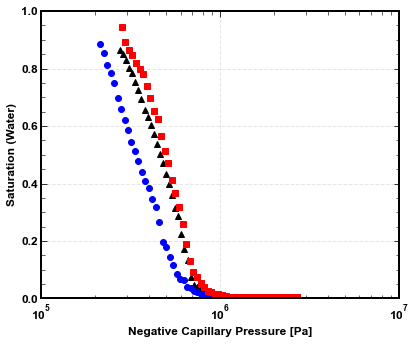

In [105]:
#interpolation to average water retention curves for each sample across regions

x_interp = []
y_interp = []

x_all_IMB = []
f_avg_IMB = []

for s,sample in enumerate(pc):
    
    sample_x_data = []
    sample_y_data = []
    sample_x_min_vals = []
    sample_x_max_vals = []
    sample_interp_funcs = []
    for r,region in enumerate(sample):
        sample_x_data.append(region)
        sample_y_data.append(sat_tot[s][r])
        sample_x_max_vals.append(max(region))
        sample_x_min_vals.append(min(region))
        sample_interp_funcs.append(interp1d(region, sat_tot[s][r]))
        
    x_max = math.floor(min(sample_x_max_vals))
    x_min = math.ceil(max(sample_x_min_vals))
    
    # define common carrier for calculation of average curve
    sample_x_all   = np.geomspace(x_min, x_max, num=50)
    
    sample_f_int = []
    for r,region in enumerate(sample):
        # evaluation of fits on common carrier
        sample_f_int.append(sample_interp_funcs[r](sample_x_all))
        
    # put all fits to one matrix for fast mean calculation
    data_collection = np.vstack(sample_f_int)

    # calculating mean value
    sample_f_avg = np.average(data_collection, axis=0)

    x_interp.append(sample_x_data)
    y_interp.append(sample_y_data)
    x_all_IMB.append(sample_x_all)
    f_avg_IMB.append(sample_f_avg)


# print(len(x_all))
#plot
fig, ax1 = plt.subplots(1, 1, figsize =[6,5])

colors =['k','b','r']
shapes = ['^','o', 's']


for s,sample in enumerate(f_avg_IMB):
    ax1.plot(x_all_IMB[s]*-1,f_avg_IMB[s],' ',color=colors[s], marker=shapes[s])

ax1.grid(color='k',alpha=0.1, linestyle='--', linewidth=1)
ax1.set_xlabel("Negative Capillary Pressure [Pa]")
ax1.set_ylabel("Saturation (Water)")
ax1.set_xscale('log')
ax1.set_xlim([10**5, 10**7])
ax1.set_ylim([0, 1])

# water_retention_pnm_pris = [x_all, f_avg]

(0.0, 1.0)

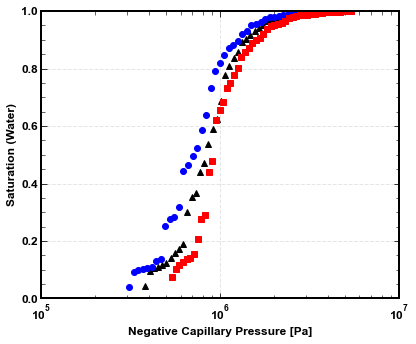

In [107]:
#interpolation to average drainage curves for each sample across regions

x_interp = []
y_interp = []

x_all_drain = []
f_avg_drain = []

for s,sample in enumerate(pc_drain):
    
    sample_x_data = []
    sample_y_data = []
    sample_x_min_vals = []
    sample_x_max_vals = []
    sample_interp_funcs = []
    for r,region in enumerate(sample):
        sample_x_data.append(region)
        sample_y_data.append(sat_tot_drain[s][r])
        sample_x_max_vals.append(max(region))
        sample_x_min_vals.append(min(region))
        sample_interp_funcs.append(interp1d(region, sat_tot_drain[s][r]))
        
    x_max = math.floor(min(sample_x_max_vals))
    x_min = math.ceil(max(sample_x_min_vals))
    
    # define common carrier for calculation of average curve
    sample_x_all   = np.geomspace(x_min, x_max, num=50)
    
    sample_f_int = []
    for r,region in enumerate(sample):
        # evaluation of fits on common carrier
        sample_f_int.append(sample_interp_funcs[r](sample_x_all))
        
    # put all fits to one matrix for fast mean calculation
    data_collection = np.vstack(sample_f_int)

    # calculating mean value
    sample_f_avg = np.average(data_collection, axis=0)

    x_interp.append(sample_x_data)
    y_interp.append(sample_y_data)
    x_all_drain.append(sample_x_all)
    f_avg_drain.append(sample_f_avg)


# print(len(x_all))
#plot
fig, ax1 = plt.subplots(1, 1, figsize =[6,5])

colors =['k','b','r']
shapes = ['^','o', 's']


for s,sample in enumerate(f_avg_drain):
    ax1.plot(x_all_drain[s],f_avg_drain[s],' ',color=colors[s], marker=shapes[s])

ax1.grid(color='k',alpha=0.1, linestyle='--', linewidth=1)
ax1.set_xlabel("Negative Capillary Pressure [Pa]")
ax1.set_ylabel("Saturation (Water)")
ax1.set_xscale('log')
ax1.set_xlim([10**5, 10**7])
ax1.set_ylim([0, 1])

# water_retention_pnm_pris = [x_all, f_avg]

In [112]:
#sample regions
title = ['Pristine', 'Uncompressed', 'Compressed']

#log normal parameters

#log normal mean (diam [nm])
ln_mu_diam = np.array([4.6565,4.9255,4.5715])
#log normal std (same for diam or radius)
ln_sigma = np.array([0.6352,0.7396,0.6127])

#log normal mean (radius) = Ln(exp(mu_diam)/2)
ln_mu_rad = np.log(np.exp(ln_mu_diam)/2)
print('ln_mu_rad: ',ln_mu_rad)

# #####cdf
# #log normal mean (diam [nm])
# ln_mu_cdf = np.array([4.0945,4.319,3.9219])
# #log normal std (same for diam or radius)
# ln_sigma_cdf = np.array([0.5339,0.6417,0.5044])

#mean value from log normal dist is E(X) = exp(mu+0.5*sigma^2)
rm = np.exp(ln_mu_rad + (ln_sigma**2/2))*10**-9
print('Rm: ',rm)

# sigma_m = np.exp(ln_sigma_cdf**2/2)

##trying to fix sigma 
# var = (rm*10**9)**2 *(np.exp(ln_sigma**2)-1)
# sigma_new = np.sqrt(sigma)
# print(sigma_new)
    

ln_mu_rad:  [3.9634 4.2324 3.8784]
Rm:  [6.4399e-08 9.0546e-08 5.8326e-08]


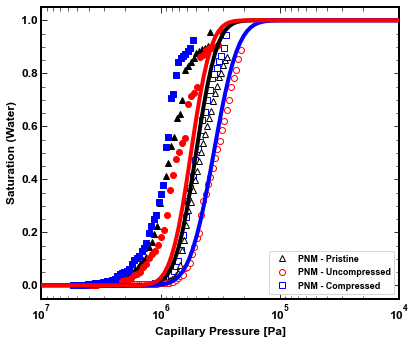

In [117]:
#plot water retention comparison between PNM and PSD values
fig1, ax1 = plt.subplots(1, 1)

colors = ['k','r','b']
zorder = [1,2,0]
shapes = ['^','o', 's']
titles = ['Pristine','Uncompressed','Compressed']

# for i,y in enumerate(sat_curves):
#     ax1.plot(-pres_cap,y, '-', color=colors[i], label='PSD - {}'.format(title[i]), markerfacecolor='white', zorder=zorder[i], 
#              markeredgewidth=1.5)
    
    
for s,sample in enumerate(f_avg_IMB):
    ax1.plot(x_all_IMB[s]*-1,f_avg_IMB[s],' ',color=colors[s], marker=shapes[s], markerfacecolor='white',zorder=zorder[s], 
             label = 'PNM - {}'.format(titles[s]))
    ax1.plot(x_all_drain[s],1-f_avg_drain[s],' ',color=colors[s], marker=shapes[s])





pcap = np.logspace(4,7,100)*-1
gamma = 0.0626
theta = 75

for i,sample in enumerate(rm):
    rk = rm[i]
    sk = ln_sigma[i]/2
    rcap = -2*gamma*np.cos(np.deg2rad(theta))/pcap
    x = np.log(rcap/rk)/(sk*np.sqrt(2))
    s = 0.5*(1+sp.special.erf(x))
    ax1.plot(pcap*-1,s,color=line_colors[i], linewidth=4,zorder=200)

ax1.set_xlabel("Capillary Pressure [Pa]")
ax1.set_ylabel("Saturation (Water)")
ax1.set_xscale('log')
ax1.set_xlim([10**7, 10**4])
ax1.set_ylim([-0.05,1.05])

ax1.legend(loc = 'lower right', fontsize=9)


plt.tick_params(axis='x', which='minor')

plt.savefig('water_retention_curves_cdf.png',\
                transparent = False, dpi = 400, bbox_inches='tight')